In [1]:
import pandas as pd
from pandas import DataFrame as dframe
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import choice
from numpy import array as arr

import jax as j
cpu = j.devices("cpu")[0]
from jax import random, vmap
import jax.numpy as jnp
import numpyro
from numpyro.distributions import *
from numpyro import sample, plate, param, deterministic
from numpyro.optim import Adam, Minimize
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import SVI, Trace_ELBO, init_to_value, Predictive

import utils
from utils import *
from utils.data import *
from utils.analysis import * # precis, cov2cor
from utils.stats import * 
from utils.plots import *
utils.init() # init plotting styles and hush warnings
seed = random.PRNGKey(8964)

## The Fork

In [181]:
seed, _ = random.split(seed)
N = 300
Z = Bernoulli(.5).sample(seed, (N,))
X = Normal(2*Z - 1, 1).sample(seed//2)
Y = Normal(2*Z - 1, 1).sample(seed//3)

In [182]:
np.corrcoef(X, Y).round(2)

array([[1. , 0.5],
       [0.5, 1. ]])

In [183]:
np.corrcoef(X[Z == 0], Y[Z == 0]).round(2)

array([[1.  , 0.02],
       [0.02, 1.  ]])

In [184]:
np.corrcoef(X[Z == 1], Y[Z == 1]).round(2)

array([[ 1.  , -0.08],
       [-0.08,  1.  ]])

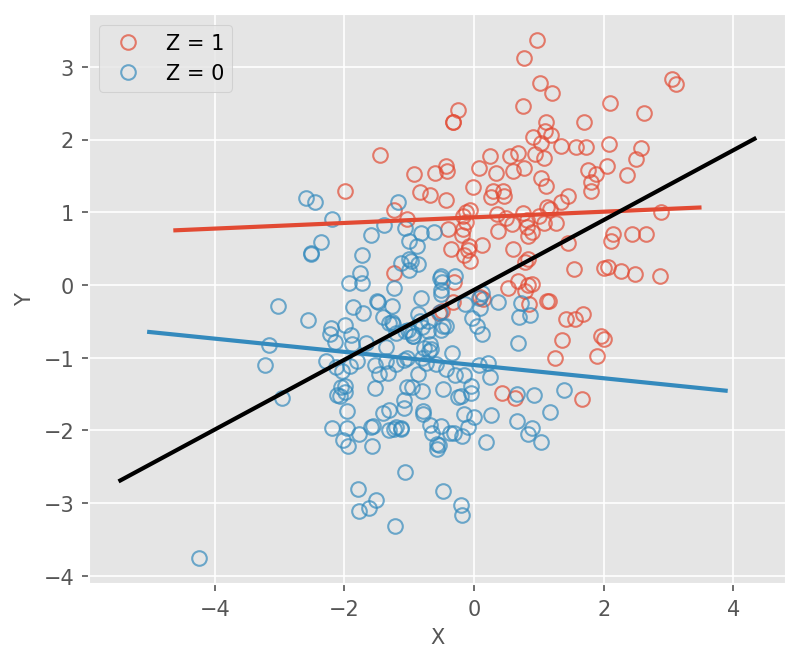

In [65]:
_, ax = plt.subplots(figsize=(6, 4))
scatter(X[Z == 1], Y[Z == 1], c="C0", label="Z = 1")
scatter(X[Z == 0], Y[Z == 0], c="C1", label="Z = 0")

abline_lm(X[Z == 1], Y[Z == 1], ax, c="C0", lw=2)
abline_lm(X[Z == 0], Y[Z == 0], ax, c="C1", lw=2)
abline_lm(X, Y, ax, lw=2)
ax.set(xlabel="X", ylabel="Y")
ax.legend();

### Fork example 

In the WaffleDivorce data, is it true that M -> D?

In [38]:
d = data("WaffleDivorce")

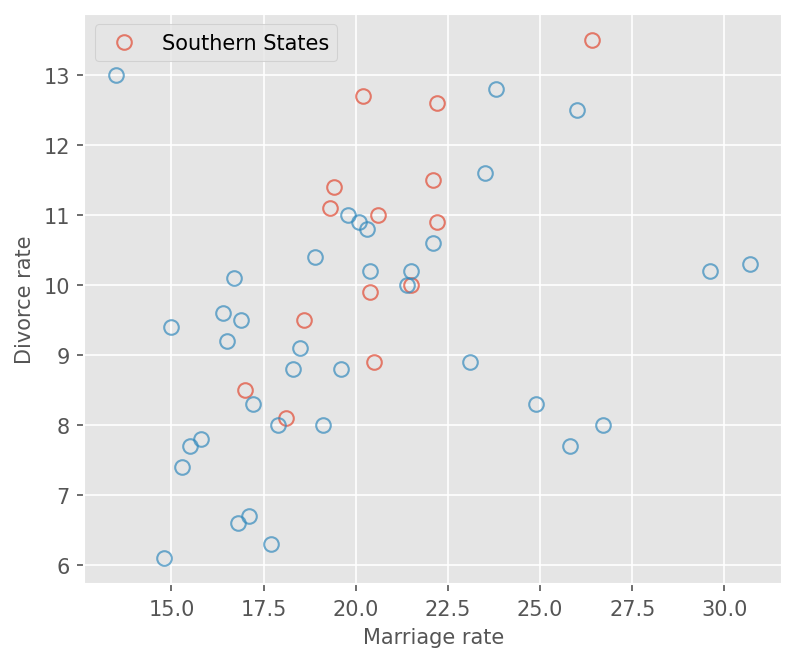

In [40]:
_, ax = plt.subplots(figsize=(6, 4))
scatter(d[d.South.astype(bool)].Marriage, d[d.South.astype(bool)].Divorce, 
        c="C0", label="Southern States")
scatter(d[~d.South.astype(bool)].Marriage, d[~d.South.astype(bool)].Divorce,
        c="C1")
ax.set(xlabel="Marriage rate", ylabel="Divorce rate")
ax.legend();

A -> D?

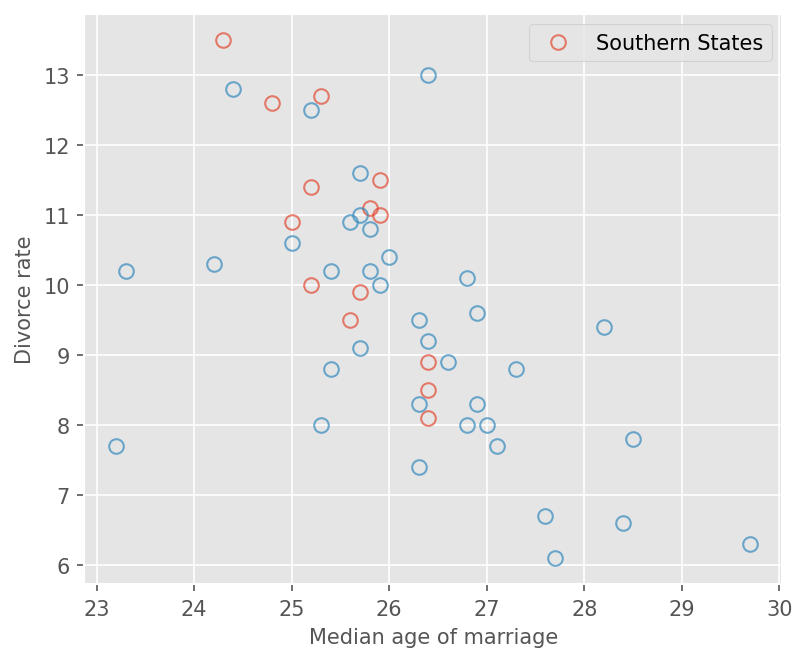

In [43]:
_, ax = plt.subplots(figsize=(6, 4))
scatter(d[d.South.astype(bool)].MedianAgeMarriage, d[d.South.astype(bool)].Divorce, 
        c="C0", label="Southern States")
scatter(d[~d.South.astype(bool)].MedianAgeMarriage, d[~d.South.astype(bool)].Divorce,
        c="C1")
ax.set(xlabel="Median age of marriage", ylabel="Divorce rate")
ax.legend();

A -> M is quite intuitive. 

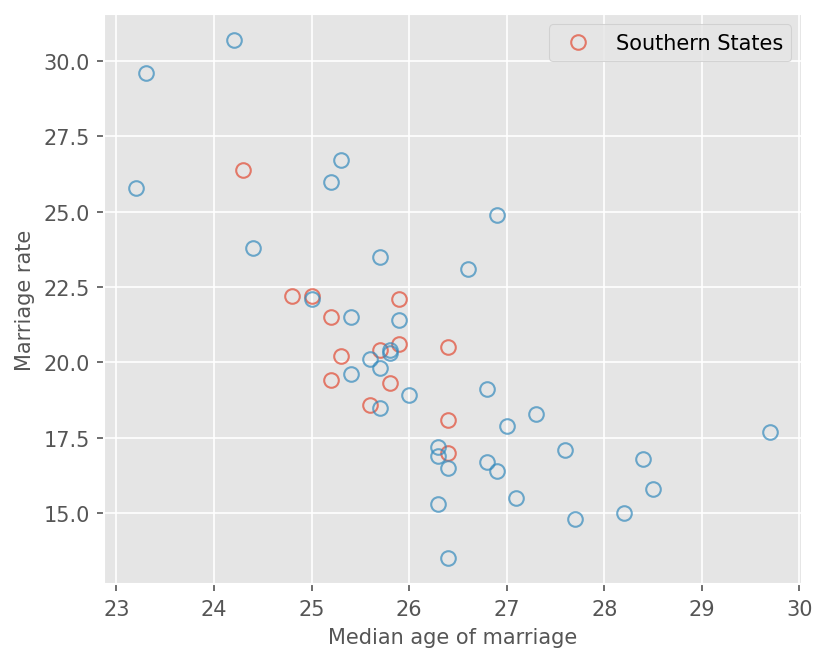

In [45]:
_, ax = plt.subplots(figsize=(6, 4))
scatter(d[d.South.astype(bool)].MedianAgeMarriage, d[d.South.astype(bool)].Marriage, 
        c="C0", label="Southern States")
scatter(d[~d.South.astype(bool)].MedianAgeMarriage, d[~d.South.astype(bool)].Marriage,
        c="C1")
ax.set(xlabel="Median age of marriage", ylabel="Marriage rate")
ax.legend();

Fork: M <- A -> D (take this as granted). So if we want to estimate M -> D, then stratify by A.

How to stratify by a continous variable? Express D as a function of A and M.

Simplest way: `D ~ A + M`. Here we have a different intercept value for each individual: $\alpha + \beta_A A_i$, that's how we stratify by this continuous A.

Every value of A possibly produces a different relationship between D and M.

### Model

$$D_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_M M_i + \beta_A A_i$$
$$\alpha \sim \text{Normal}(?, ?)$$
$$\beta_M \sim \text{Normal}(?, ?)$$
$$\beta_A \sim \text{Normal}(?, ?)$$
$$\sigma \sim \text{Exponential}(?)$$

### Prior predictive simulation

Let's impose some flat priors on the parameters.

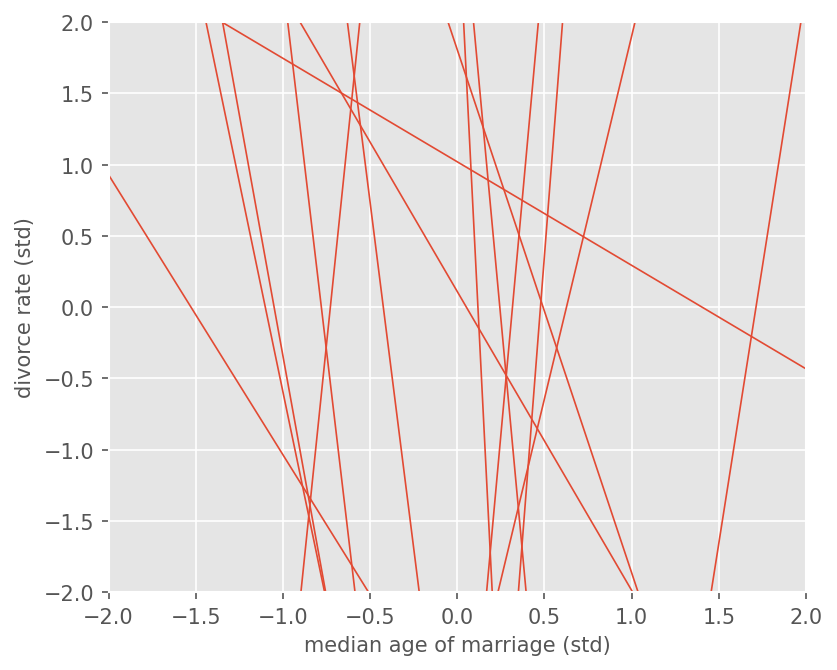

In [107]:
n = 20
seed, _ = random.split(seed)
a = Normal(0, 10).sample(seed//5, (n,))
bM = Normal(0, 10).sample(seed//7, (n,))
bA = Normal(0, 10).sample(seed//11, (n,)) 

_, ax = plt.subplots(figsize=(6, 4))
ax.set(xlim=[-2, 2], ylim=[-2, 2], 
       xlabel="median age of marriage (std)",
       ylabel="divorce rate (std)")
Aseq = np.linspace(-3, 3, 30)
for i in range(n):
    mu = a[i] + bA[i]*Aseq
    ax.plot(Aseq, mu, color="C0")

Better priors

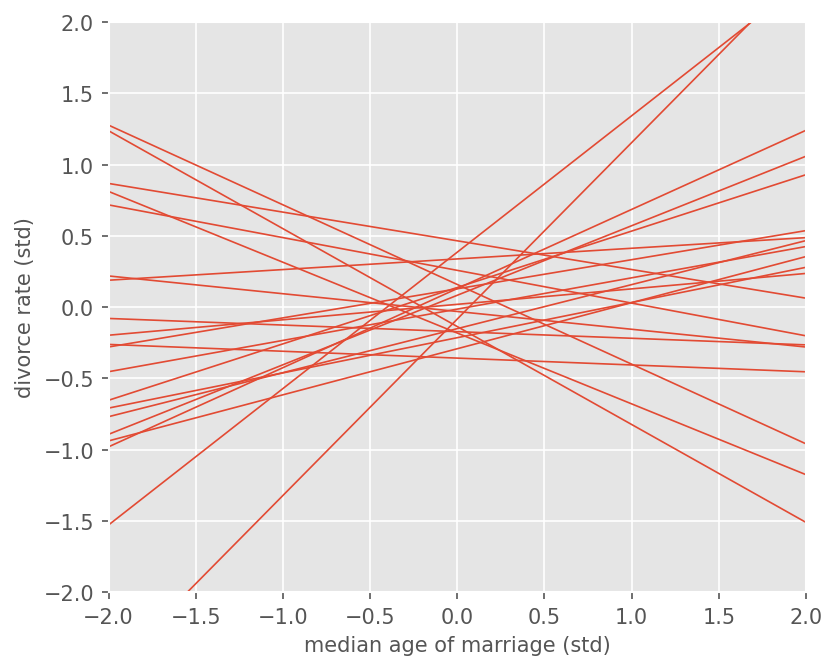

In [108]:
n = 20
seed, _ = random.split(seed)
a = Normal(0, .2).sample(seed//5, (n,))
bM = Normal(0, .5).sample(seed//7, (n,))
bA = Normal(0, .5).sample(seed//11, (n,)) 

_, ax = plt.subplots(figsize=(6, 4))
ax.set(xlim=[-2, 2], ylim=[-2, 2], 
       xlabel="median age of marriage (std)",
       ylabel="divorce rate (std)")
Aseq = np.linspace(-3, 3, 30)
for i in range(n):
    mu = a[i] + bA[i]*Aseq
    ax.plot(Aseq, mu, color="C0")

### Analyze the data

In [111]:
dat = dict(D=scale(d.Divorce.values),
           M=scale(d.Marriage.values),
           A=scale(d.MedianAgeMarriage.values)
          )


def f_DMA(A, M, D=None):
    a = sample("a", Normal(0, .2))
    bM = sample("bM", Normal(0, .5))
    bA = sample("bA", Normal(0, .5))
    sigma = sample("sigma", Exponential(1))
    mu = deterministic("mu", a + bM*M + bA*A)
    sample("D", Normal(mu, sigma), obs=D)
    

m_DMA = AutoLaplaceApproximation(f_DMA)
p_DMA = (SVI(f_DMA, m_DMA, Adam(1), Trace_ELBO())
            .run(seed, 2000, **dat).params)

100%|████████████████████████| 2000/2000 [00:01<00:00, 1717.39it/s, init loss: 566.0779, avg. loss [1901-2000]: 61.2910]


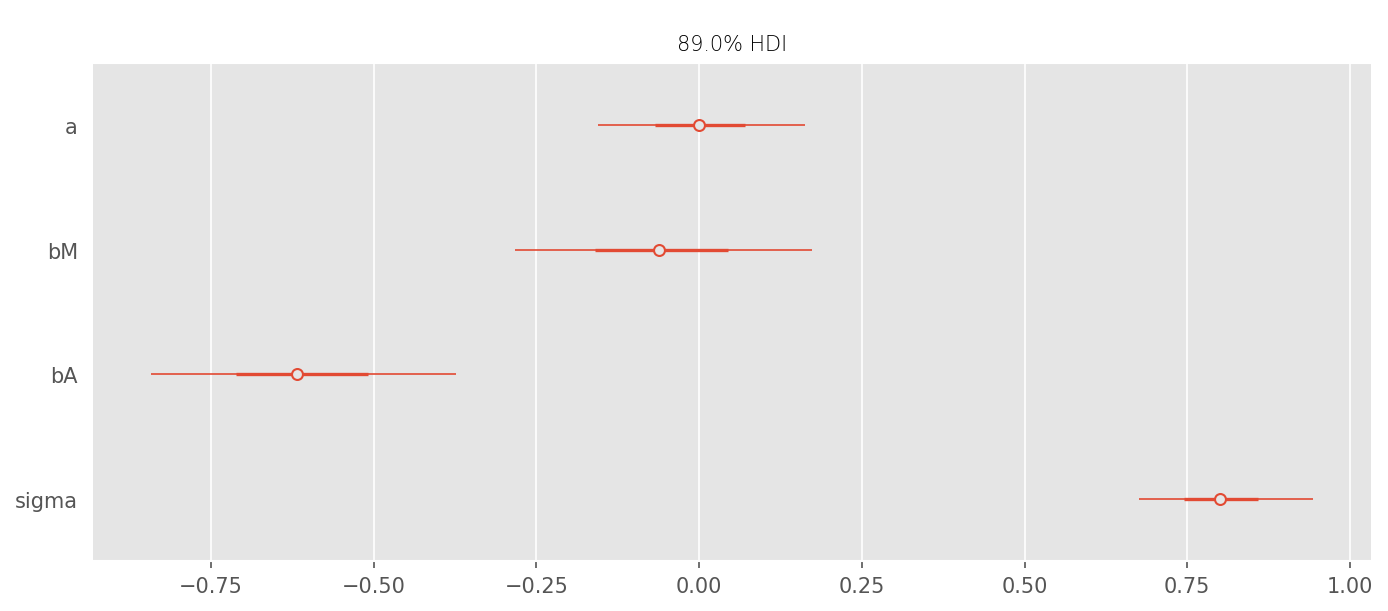

In [117]:
post_DMA = m_DMA.sample_posterior(seed, p_DMA, (1, 1000))
_, ax = plt.subplots()
az.plot_forest(post_DMA, var_names=["a", "bM", "bA", "sigma"], ax=ax);

What's the causal effect of M on D?

Usually we report the value of the slope. But generally not legit.

We should report $p(D|do(M))$ by simulation from the learned model.

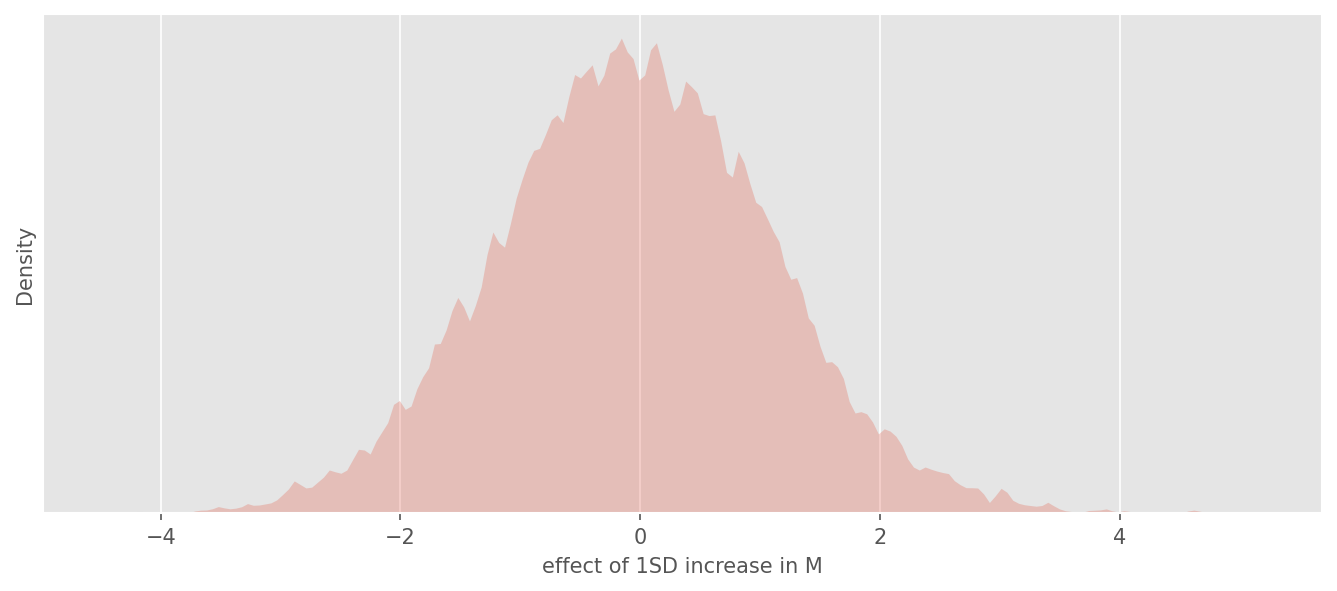

In [140]:
n = 100
post_DMA = m_DMA.sample_posterior(seed, p_DMA, (n,))

# sample A from the data
As = choice(dat["A"], n, replace=True)

# simulate D for M=0 (M at sample mean)
DM0 = Predictive(f_DMA, post_DMA, return_sites=["D"]) \
                (seed, A=As, M=0)["D"].flatten()

# simulate D for M=1 (M at +1 sample SD)
seed, _ = random.split(seed)
DM1 = Predictive(f_DMA, post_DMA, return_sites=["D"]) \
                (seed, A=As, M=1)["D"].flatten()

# contrast 
M10_contrast = DM1 - DM0
ax = plt.subplot()
dens(M10_contrast, bw_adjust=.2)
ax.set(xlabel="effect of 1SD increase in M",
       yticks=[]);

Can't say there's no M -> D effect because the variability in the contrasts is large, even if they are centered at zero.

## The Pipe

In [168]:
n = 1000
X = Bernoulli(.5).sample(seed, (n,))
Z = Bernoulli((1 - X)*0.1 + X*0.9).sample(seed//101)
Y = Bernoulli((1 - Z)*0.1 + Z*0.9).sample(seed//137)

In [169]:
np.corrcoef(X, Y).round(2)

array([[1.  , 0.61],
       [0.61, 1.  ]])

In [170]:
np.corrcoef(X[Z == 0], Y[Z == 0]).round(2)

array([[1., 0.],
       [0., 1.]])

In [171]:
np.corrcoef(X[Z == 1], Y[Z == 1]).round(2)

array([[ 1.  , -0.04],
       [-0.04,  1.  ]])

## The collider

In [44]:
n = 1000
seed, _ = random.split(seed)
X = Bernoulli(.5).sample(seed, (n,))
Y = Bernoulli(.5).sample(seed//37, (n,))
Z = Bernoulli(np.where(X + Y > 0, 0.9, 0.2)).sample(seed//59)

In [45]:
np.corrcoef(X, Y).round(2)

array([[1., 0.],
       [0., 1.]])

In [46]:
np.corrcoef(X[Z == 0], Y[Z == 0]).round(2)

array([[1.  , 0.36],
       [0.36, 1.  ]])

In [47]:
np.corrcoef(X[Z == 1], Y[Z == 1]).round(2)

array([[ 1.  , -0.34],
       [-0.34,  1.  ]])

In [38]:
n = 1000
seed, _ = random.split(seed)
X = Normal(0, 1).sample(seed, (n,))
Y = Normal(0, 1).sample(seed//37, (n,))
Z = Normal(np.where(X + Y > 0, 3, -3), 1).sample(seed//59)

In [42]:
import statsmodels.api as sm
(sm.OLS(Y, dframe(dict(X=X)))
   .fit()
   .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.001
Method:                 Least Squares   F-statistic:                             0.4190
Date:                Sun, 23 Apr 2023   Prob (F-statistic):                       0.518
Time:                        23:14:49   Log-Likelihood:                         -1416.3
No. Observations:                1000   AIC:                                      2835.
Df Residuals:                     999   BIC:                                      2840.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.0219      0.034      0.647      0.518      -0.044       0.088
==============================================================================
Omnibus:                        0.492   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.782   Jarque-Bera (JB):                0.579
Skew:                          -0.007   Prob(JB):                        0.749
Kurtosis:                       2.883   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
(sm.OLS(Y, dframe(dict(X=X, Z=Z)))
   .fit()
   .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.429
Model:                            OLS   Adj. R-squared (uncentered):              0.428
Method:                 Least Squares   F-statistic:                              375.2
Date:                Sun, 23 Apr 2023   Prob (F-statistic):                   3.10e-122
Time:                        23:15:17   Log-Likelihood:                         -1136.2
No. Observations:                1000   AIC:                                      2276.
Df Residuals:                     998   BIC:                                      2286.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -0.3716      0.029    -12.669      0.000      -0.429      -0.314
Z              0.2319      0.008     27.380      0.000       0.215       0.249
==============================================================================
Omnibus:                        0.406   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.816   Jarque-Bera (JB):                0.301
Skew:                          -0.024   Prob(JB):                        0.860
Kurtosis:                       3.070   Cond. No.                         4.06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Watermark

In [48]:
%reload_ext watermark
%watermark -v -iv -u -dt

Last updated: 2023-04-23 23:19:52

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.12.0

pandas     : 2.0.0
arviz      : 0.15.1
statsmodels: 0.13.5
jax        : 0.4.8
numpyro    : 0.11.0
xarray     : 2023.4.2
numpy      : 1.24.3
seaborn    : 0.12.2
matplotlib : 3.7.1

